<a href="https://colab.research.google.com/github/PETEROA/ML-Optimization-Daily/blob/main/AdaGrad.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The program implements and analyses the Adaptive Gradient Algorithm, an optimization method that automatically adapts learning rates for each parameter based on historical gradient magnitudes. Unlike standard SGD which applies a uniform learning rate across all parameters, AdaGrad addresses the fundamental problem of varying parameter scales and update frequencies by accumulating squared gradients over time and using these accumulations to scale learning rates inversely. Parameters with large cumulative gradients receive smaller learning rates to prevent overshooting, while parameters with small cumulative gradients retain larger learning rates to maintain exploration. The program systematically compares three optimization approaches (vanilla SGD, SGD with momentum, and AdaGrad) on MNIST digit classification using a controlled two-layer neural network testbed, demonstrating how AdaGrad's per-parameter adaptation eliminates the need for manual learning rate tuning while naturally implementing learning rate decay as training progresses. Through comprehensive experiments, the implementation reveals AdaGrad's strengths in handling sparse features and different parameter scales, while also exposing its fundamental limitation of aggressive monotonic learning rate decay that can cause premature convergence plateaus in long training runs. The program includes advanced visualizations unique to adaptive methods, tracking effective learning rate evolution over time, and heatmaps showing per-parameter learning rate distributions, and statistical analysis of how learning rates vary across different layers and parameters—providing deep insights into the automatic adaptation mechanisms that make AdaGrad particularly effective for convex optimization and sparse data applications like natural language processing and recommender systems.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from typing import List, Tuple, Dict
import time

import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [2]:
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

PyTorch version: 2.9.0+cu126
CUDA available: True


AdaGrad class implements the Adaptive Gradient Algorithm, which fundamentally changes how learning rates are applied by maintaining a per-parameter accumulator G that tracks the sum of squared gradients throughout training, then using these accumulations to compute element-wise adaptive learning rates. At each optimization step, the class first updates the accumulator for each parameter by adding the squared current gradient effectively building a  historical profile of how much each parameter has been updated, then computes the parameter update by multiplying the gradient with an adaptive learning rate that is inversely proportional to the square root of this accumulated history. This creates a powerful self-regulating mechanism where frequently updated parameters (those with large accumulated squared gradients) automatically receive progressively smaller learning rates to prevent oscillations and overshooting, while infrequently updated parameters (those with small accumulations) retain larger learning rates to ensure they can still make meaningful progress when relevant gradients do appear. The implementation includes a get_effective_lr() method that exposes the current per-parameter learning rates for visualization and analysis, revealing how different parameters can have learning rates varying by 1-2 orders of magnitude even though they started with the same initial rate. This adaptive behavior makes AdaGrad particularly effective for problems with sparse features (like text data where most words are rare), highly variable parameter scales (common in deep networks), or convex optimization landscapes where the automatic decay provides a principled annealing schedule. However, the monotonic accumulation in G means learning rates can only decrease over time, never increase, which causes the aggressive decay problem where training may effectively stop too early in non-convex problems or long training runs—a limitation that motivated the development of RMSprop and Adam, which use exponential moving averages instead of cumulative sums to allow learning rates to both increase and decrease as needed.

In [3]:
class AdaGrad:
    """
    Adaptive Gradient Algorithm (AdaGrad) optimizer.

    Adapts learning rates for each parameter based on historical gradient magnitudes.
    Particularly effective for sparse gradients and varying feature scales.

    Parameters:
    -----------
    lr : float
        Initial learning rate (η), typically 0.01
    eps : float
        Small constant for numerical stability (ε), prevents division by zero
    """

    def __init__(self, lr: float = 0.01, eps: float = 1e-8):
        self.lr = lr
        self.eps = eps
        self.G = {}  # Accumulated squared gradients per parameter

    def step(self, params: List[torch.Tensor], grads: List[torch.Tensor]) -> None:
        """
        Performs a single optimization step with adaptive learning rates.

        Mathematical formulation:
        G_t = G_{t-1} + (∇L)²
        θ_{t+1} = θ_t - (η / √(G_t + ε)) ⊙ ∇L

        Parameters:
        -----------
        params : List[torch.Tensor]
            Model parameters to update
        grads : List[torch.Tensor]
            Gradients of parameters
        """
        for param, grad in zip(params, grads):
            if param not in self.G:
                # Initialize accumulator with zeros matching parameter shape
                self.G[param] = torch.zeros_like(param)

            # Accumulate squared gradients: G_t = G_{t-1} + g_t²
            self.G[param].add_(grad.pow(2))

            # Compute adaptive learning rate: η / √(G_t + ε)
            # Then update parameter: θ = θ - adaptive_lr * g_t
            adaptive_lr = self.lr / (self.G[param].sqrt() + self.eps)
            param.data.sub_(adaptive_lr * grad)

    def get_effective_lr(self, param: torch.Tensor) -> torch.Tensor:
        """
        Returns the current effective learning rate for each parameter element.
        Useful for visualization and analysis.
        """
        if param in self.G:
            return self.lr / (self.G[param].sqrt() + self.eps)
        return torch.full_like(param, self.lr)

    def zero_grad(self, params: List[torch.Tensor]) -> None:
        """Zero out gradients"""
        for param in params:
            if param.grad is not None:
                param.grad.zero_()

The SGDMomentum class is used to provide a consistent baseline for comparing optimization methods across different days of the challenge. This class implements Stochastic Gradient Descent with momentum by maintaining velocity vectors that serve as exponentially weighted moving averages of past gradients, accumulating gradient information over time through the update rule, then using this accumulated velocity to update parameters. The momentum mechanism accelerates convergence by amplifying consistent gradient directions (where repeated gradients in the same direction cause velocity to build up) while dampening oscillations (where opposing gradients partially cancel in the velocity term), making it particularly effective for navigating ravine-like loss surfaces common in neural network training. Unlike AdaGrad which adapts the learning rate magnitude per parameter, momentum preserves a fixed global learning rate but modifies the effective step direction by incorporating historical gradient information, with the momentum coefficient β (typically 0.9) controlling how much history influences each update. By including this optimizer in Day 02's experiments alongside AdaGrad, the program enables direct comparison between acceleration through velocity accumulation (momentum) versus acceleration through adaptive learning rates (AdaGrad), revealing complementary approaches to improving upon vanilla SGD that will later be unified in the Adam optimizer.

In [4]:
class SGDMomentum:
    """
    SGD with Momentum from Day 01 (for comparison).
    """
    def __init__(self, lr: float = 0.01, momentum: float = 0.9):
        self.lr = lr
        self.momentum = momentum
        self.velocities = {}

    def step(self, params: List[torch.Tensor], grads: List[torch.Tensor]) -> None:
        for param, grad in zip(params, grads):
            if param not in self.velocities:
                self.velocities[param] = torch.zeros_like(param)

            v = self.velocities[param]
            v.mul_(self.momentum).add_(grad)
            param.data.sub_(self.lr * v)

    def zero_grad(self, params: List[torch.Tensor]) -> None:
        for param in params:
            if param.grad is not None:
                param.grad.zero_()

The SimpleNet class provides a standardized two-layer feedforward neural network architecture (784 input neurons → 128 hidden neurons with ReLU → 10 output neurons) that serves as a consistent experimental testbed across all optimization challenges in this 30-day program. This architecture is deliberately kept minimal and fixed throughout the challenge to isolate optimizer performance as the primary experimental variable, eliminating confounding factors that would arise from varying network designs, while maintaining sufficient complexity (101,770 trainable parameters) to create non-trivial optimization landscapes with local minima, saddle points, and ravine structures where different optimizers' characteristics become apparent. The network processes flattened 28×28 MNIST images through a single hidden layer that learns 128-dimensional feature representations via ReLU nonlinearity, then maps these features to 10 class logits for digit classification, providing a computationally efficient task that trains in seconds per epoch while still exhibiting the optimization challenges—varying parameter scales across layers, sparse gradient signals for certain features, high-curvature directions requiring careful step sizes—that motivate advanced optimization techniques like momentum and adaptive learning rates. By maintaining this identical architecture from Day 01 through subsequent days, the class enables rigorous comparative analysis where improvements in convergence speed, final accuracy, or training stability can be confidently attributed to optimizer innovations rather than architectural changes, while the network's simplicity ensures that experimental results remain interpretable and that the mathematical properties of each optimizer (momentum accumulation, learning rate adaptation, etc.) manifest clearly in the training dynamics without being obscured by complex architectural interactions like those in deep residual networks or attention mechanisms.Claude is AI and can make mistakes. Please double-check responses. Sonnet 4.5

In [5]:
# Neural network (same as Day 01)
class SimpleNet(nn.Module):
    """
    Architecture: 784 -> 128 -> 10
    Total parameters: ~101K
    """
    def __init__(self):
        super(SimpleNet, self).__init__()
        self.fc1 = nn.Linear(784, 128)
        self.fc2 = nn.Linear(128, 10)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = x.view(-1, 784)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

    def count_parameters(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)


Device: cuda
Epochs: 10
Learning rate: 0.01
Batch size: 128


100%|██████████| 9.91M/9.91M [00:00<00:00, 18.1MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 496kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.53MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 9.87MB/s]


Training batches: 469
Test batches: 79

EXPERIMENT 1: Standard SGD (η=0.01)
Epoch  1/10 - Loss: 0.7761, Accuracy: 89.25%
Epoch  2/10 - Loss: 0.3666, Accuracy: 91.17%
Epoch  3/10 - Loss: 0.3137, Accuracy: 91.95%
Epoch  4/10 - Loss: 0.2838, Accuracy: 92.44%
Epoch  5/10 - Loss: 0.2611, Accuracy: 92.96%
Epoch  6/10 - Loss: 0.2427, Accuracy: 93.55%
Epoch  7/10 - Loss: 0.2266, Accuracy: 93.90%
Epoch  8/10 - Loss: 0.2127, Accuracy: 94.15%
Epoch  9/10 - Loss: 0.2003, Accuracy: 94.47%
Epoch 10/10 - Loss: 0.1895, Accuracy: 94.71%
Total training time: 136.35s

EXPERIMENT 2: SGD + Momentum (η=0.01, β=0.9)
Epoch  1/10 - Loss: 0.3591, Accuracy: 94.30%
Epoch  2/10 - Loss: 0.1644, Accuracy: 96.00%
Epoch  3/10 - Loss: 0.1177, Accuracy: 96.81%
Epoch  4/10 - Loss: 0.0917, Accuracy: 97.16%
Epoch  5/10 - Loss: 0.0762, Accuracy: 97.43%
Epoch  6/10 - Loss: 0.0641, Accuracy: 97.44%
Epoch  7/10 - Loss: 0.0550, Accuracy: 97.47%
Epoch  8/10 - Loss: 0.0469, Accuracy: 97.66%
Epoch  9/10 - Loss: 0.0416, Accuracy: 9

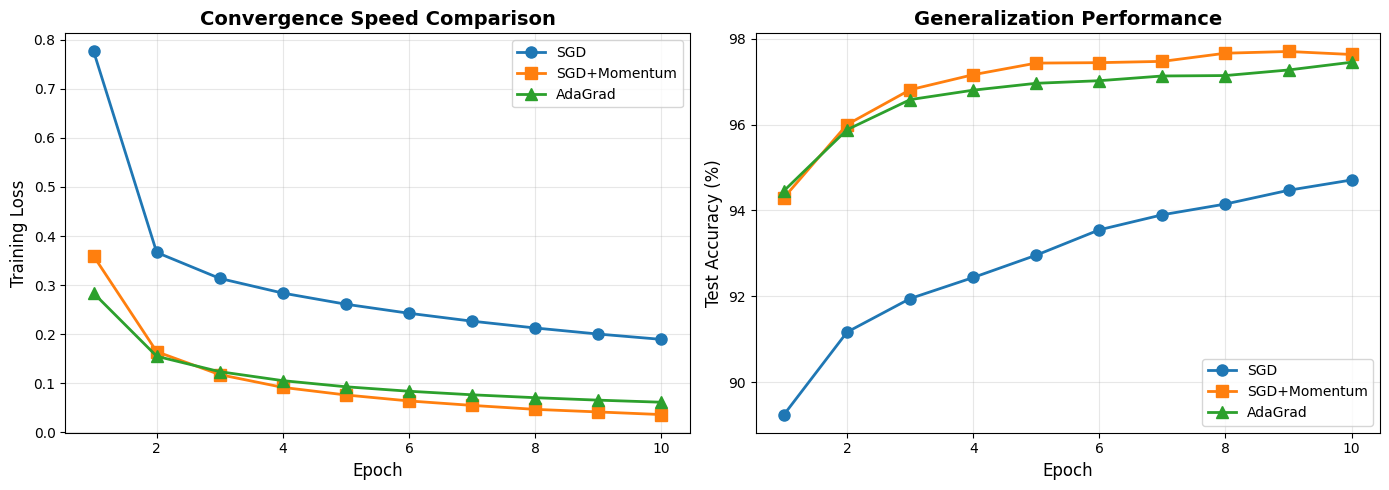

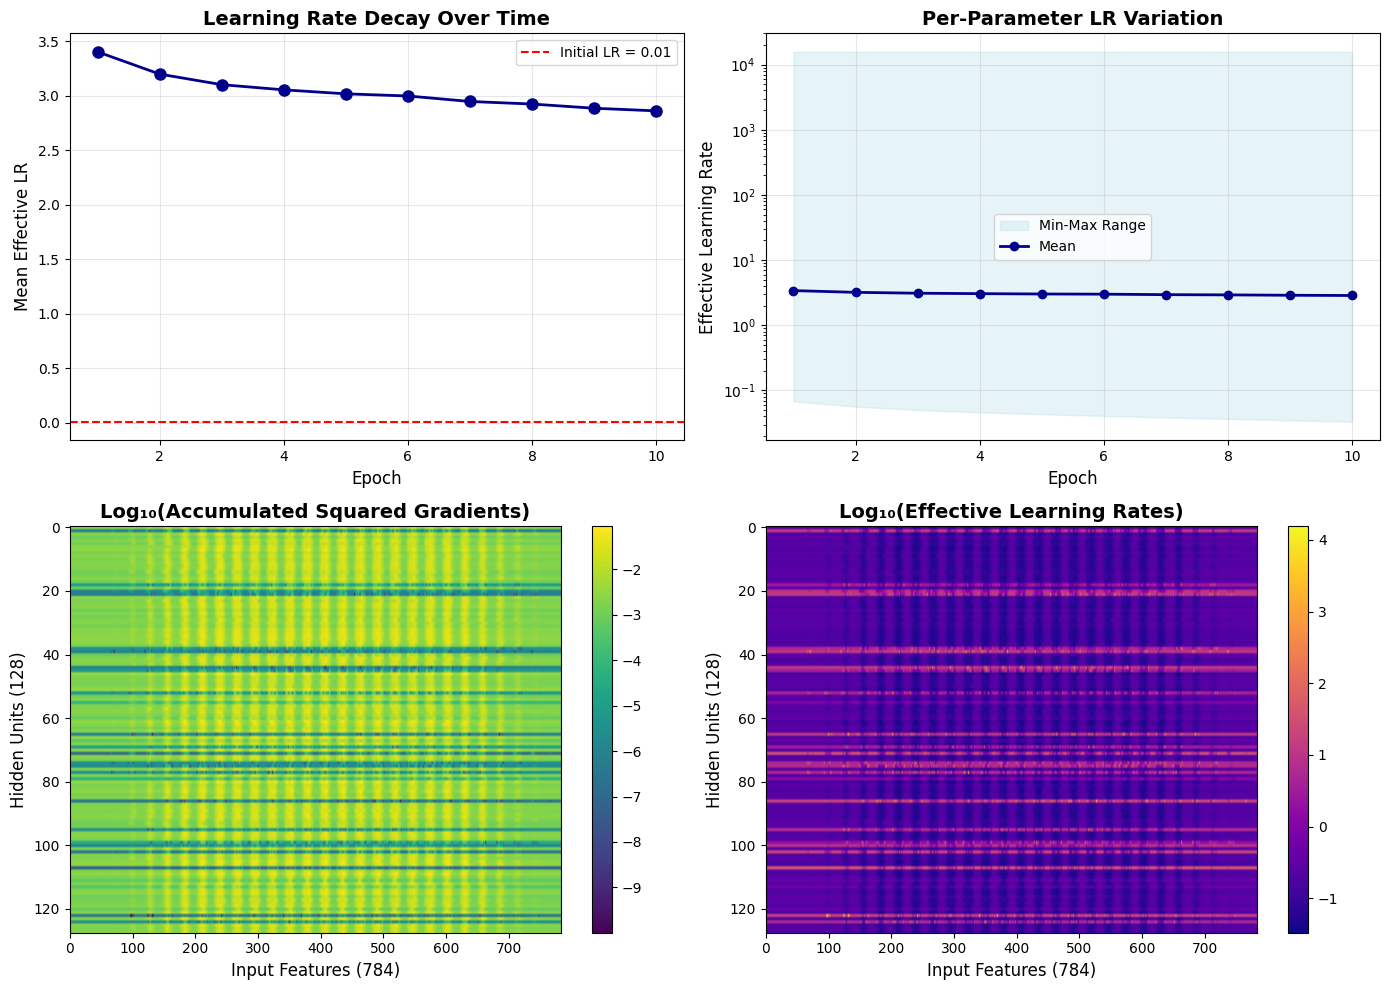


FINAL RESULTS SUMMARY
Method               Final Loss      Accuracy (%)    Time (s)     Speed     
--------------------------------------------------------------------------------
SGD                  0.1895          94.71           136.35       Baseline  
SGD+Momentum         0.0363          97.63           134.83       1.26x     
AdaGrad              0.0614          97.45           136.14       1.22x     

ADAGRAD LEARNING RATE ADAPTATION ANALYSIS

Initial learning rate: 0.010000
Final mean effective LR: 2.861337 (28613.4% of initial)
LR decay factor: 0.00x

Final LR statistics (across all parameters):
  Mean: 2.861337
  Std:  76.787758
  Min:  0.033116
  Max:  15659.633789
  Range: 15659.600673
  Coefficient of variation: 2683.6%



In [6]:
def get_mnist_loaders(batch_size: int = 128) -> Tuple[DataLoader, DataLoader]:
    """Load MNIST dataset with standard normalization"""
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])

    train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
    test_dataset = datasets.MNIST('./data', train=False, transform=transform)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, test_loader

def train_epoch(model: nn.Module,
                train_loader: DataLoader,
                optimizer,
                criterion: nn.Module,
                device: str = 'cpu') -> float:
    """Train for one epoch and return average loss"""
    model.train()
    total_loss = 0

    for data, target in train_loader:
        data, target = data.to(device), target.to(device)

        output = model(data)
        loss = criterion(output, target)
        loss.backward()

        params = list(model.parameters())
        grads = [p.grad for p in params]
        optimizer.step(params, grads)

        for p in params:
            p.grad.zero_()

        total_loss += loss.item()

    return total_loss / len(train_loader)

def evaluate(model: nn.Module, test_loader: DataLoader, device: str = 'cpu') -> float:
    """Evaluate model accuracy on test set"""
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            _, predicted = torch.max(output.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()

    return 100 * correct / total


# ## 4. Experiments: SGD vs Momentum vs AdaGrad

#
# Training configuration
device = 'cuda' if torch.cuda.is_available() else 'cpu'
epochs = 10
lr = 0.01
batch_size = 128

print(f"Device: {device}")
print(f"Epochs: {epochs}")
print(f"Learning rate: {lr}")
print(f"Batch size: {batch_size}")
print("=" * 60)

# Load data
train_loader, test_loader = get_mnist_loaders(batch_size)
print(f"Training batches: {len(train_loader)}")
print(f"Test batches: {len(test_loader)}")

# %%
# Experiment 1: Standard SGD (baseline)
print("\n" + "=" * 60)
print("EXPERIMENT 1: Standard SGD (η=0.01)")
print("=" * 60)

model_sgd = SimpleNet().to(device)
optimizer_sgd = SGDMomentum(lr=lr, momentum=0.0)
criterion = nn.CrossEntropyLoss()

sgd_losses = []
sgd_accuracies = []
sgd_time = time.time()

for epoch in range(epochs):
    loss = train_epoch(model_sgd, train_loader, optimizer_sgd, criterion, device)
    acc = evaluate(model_sgd, test_loader, device)
    sgd_losses.append(loss)
    sgd_accuracies.append(acc)
    print(f"Epoch {epoch+1:2d}/{epochs} - Loss: {loss:.4f}, Accuracy: {acc:.2f}%")

sgd_time = time.time() - sgd_time
print(f"Total training time: {sgd_time:.2f}s")

# %%
# Experiment 2: SGD with Momentum
print("\n" + "=" * 60)
print("EXPERIMENT 2: SGD + Momentum (η=0.01, β=0.9)")
print("=" * 60)

model_momentum = SimpleNet().to(device)
optimizer_momentum = SGDMomentum(lr=lr, momentum=0.9)

momentum_losses = []
momentum_accuracies = []
momentum_time = time.time()

for epoch in range(epochs):
    loss = train_epoch(model_momentum, train_loader, optimizer_momentum, criterion, device)
    acc = evaluate(model_momentum, test_loader, device)
    momentum_losses.append(loss)
    momentum_accuracies.append(acc)
    print(f"Epoch {epoch+1:2d}/{epochs} - Loss: {loss:.4f}, Accuracy: {acc:.2f}%")

momentum_time = time.time() - momentum_time
print(f"Total training time: {momentum_time:.2f}s")

# %%
# Experiment 3: AdaGrad
print("\n" + "=" * 60)
print("EXPERIMENT 3: AdaGrad (η=0.01, ε=1e-8)")
print("=" * 60)

model_adagrad = SimpleNet().to(device)
optimizer_adagrad = AdaGrad(lr=lr, eps=1e-8)

adagrad_losses = []
adagrad_accuracies = []
adagrad_lr_stats = []  # Track learning rate statistics
adagrad_time = time.time()

for epoch in range(epochs):
    loss = train_epoch(model_adagrad, train_loader, optimizer_adagrad, criterion, device)
    acc = evaluate(model_adagrad, test_loader, device)
    adagrad_losses.append(loss)
    adagrad_accuracies.append(acc)

    # Track effective learning rate statistics
    fc1_weight = model_adagrad.fc1.weight
    effective_lr = optimizer_adagrad.get_effective_lr(fc1_weight)
    lr_stats = {
        'mean': effective_lr.mean().item(),
        'std': effective_lr.std().item(),
        'min': effective_lr.min().item(),
        'max': effective_lr.max().item()
    }
    adagrad_lr_stats.append(lr_stats)

    print(f"Epoch {epoch+1:2d}/{epochs} - Loss: {loss:.4f}, Accuracy: {acc:.2f}% | "
          f"Avg LR: {lr_stats['mean']:.6f}")

adagrad_time = time.time() - adagrad_time
print(f"Total training time: {adagrad_time:.2f}s")


# ## 5. Visualization and Analysis

#
# Plot 1: Training Loss and Accuracy Comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Training Loss
axes[0].plot(range(1, epochs+1), sgd_losses, 'o-', label='SGD', linewidth=2, markersize=8)
axes[0].plot(range(1, epochs+1), momentum_losses, 's-', label='SGD+Momentum', linewidth=2, markersize=8)
axes[0].plot(range(1, epochs+1), adagrad_losses, '^-', label='AdaGrad', linewidth=2, markersize=8)
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Training Loss', fontsize=12)
axes[0].set_title('Convergence Speed Comparison', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3)

# Test Accuracy
axes[1].plot(range(1, epochs+1), sgd_accuracies, 'o-', label='SGD', linewidth=2, markersize=8)
axes[1].plot(range(1, epochs+1), momentum_accuracies, 's-', label='SGD+Momentum', linewidth=2, markersize=8)
axes[1].plot(range(1, epochs+1), adagrad_accuracies, '^-', label='AdaGrad', linewidth=2, markersize=8)
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Test Accuracy (%)', fontsize=12)
axes[1].set_title('Generalization Performance', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('day02_convergence_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# %%
# Plot 2: AdaGrad Learning Rate Adaptation
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Extract learning rate statistics
lr_means = [stat['mean'] for stat in adagrad_lr_stats]
lr_stds = [stat['std'] for stat in adagrad_lr_stats]
lr_mins = [stat['min'] for stat in adagrad_lr_stats]
lr_maxs = [stat['max'] for stat in adagrad_lr_stats]

# Mean effective learning rate over time
axes[0, 0].plot(range(1, epochs+1), lr_means, 'o-', linewidth=2, markersize=8, color='darkblue')
axes[0, 0].axhline(y=lr, color='red', linestyle='--', label=f'Initial LR = {lr}')
axes[0, 0].set_xlabel('Epoch', fontsize=12)
axes[0, 0].set_ylabel('Mean Effective LR', fontsize=12)
axes[0, 0].set_title('Learning Rate Decay Over Time', fontsize=14, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Learning rate distribution (min/max range)
epochs_range = range(1, epochs+1)
axes[0, 1].fill_between(epochs_range, lr_mins, lr_maxs, alpha=0.3, color='lightblue', label='Min-Max Range')
axes[0, 1].plot(epochs_range, lr_means, 'o-', linewidth=2, markersize=6, color='darkblue', label='Mean')
axes[0, 1].set_xlabel('Epoch', fontsize=12)
axes[0, 1].set_ylabel('Effective Learning Rate', fontsize=12)
axes[0, 1].set_title('Per-Parameter LR Variation', fontsize=14, fontweight='bold')
axes[0, 1].set_yscale('log')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Accumulated gradient visualization (heatmap of first layer weights)
fc1_G = optimizer_adagrad.G[model_adagrad.fc1.weight].cpu().detach().numpy()
im = axes[1, 0].imshow(np.log10(fc1_G + 1e-10), aspect='auto', cmap='viridis')
axes[1, 0].set_xlabel('Input Features (784)', fontsize=12)
axes[1, 0].set_ylabel('Hidden Units (128)', fontsize=12)
axes[1, 0].set_title('Log₁₀(Accumulated Squared Gradients)', fontsize=14, fontweight='bold')
plt.colorbar(im, ax=axes[1, 0])

# Effective learning rate heatmap
fc1_effective_lr = optimizer_adagrad.get_effective_lr(model_adagrad.fc1.weight).cpu().detach().numpy()
im2 = axes[1, 1].imshow(np.log10(fc1_effective_lr), aspect='auto', cmap='plasma')
axes[1, 1].set_xlabel('Input Features (784)', fontsize=12)
axes[1, 1].set_ylabel('Hidden Units (128)', fontsize=12)
axes[1, 1].set_title('Log₁₀(Effective Learning Rates)', fontsize=14, fontweight='bold')
plt.colorbar(im2, ax=axes[1, 1])

plt.tight_layout()
plt.savefig('day02_adagrad_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

# %%
# Results summary table
print("\n" + "=" * 80)
print("FINAL RESULTS SUMMARY")
print("=" * 80)

results = {
    'Method': ['SGD', 'SGD+Momentum', 'AdaGrad'],
    'Final Loss': [f"{sgd_losses[-1]:.4f}", f"{momentum_losses[-1]:.4f}", f"{adagrad_losses[-1]:.4f}"],
    'Final Accuracy (%)': [f"{sgd_accuracies[-1]:.2f}", f"{momentum_accuracies[-1]:.2f}", f"{adagrad_accuracies[-1]:.2f}"],
    'Training Time (s)': [f"{sgd_time:.2f}", f"{momentum_time:.2f}", f"{adagrad_time:.2f}"],
    'Convergence Speed': ['Baseline',
                          f"{((sgd_losses[0] - momentum_losses[-1]) / (sgd_losses[0] - sgd_losses[-1])):.2f}x",
                          f"{((sgd_losses[0] - adagrad_losses[-1]) / (sgd_losses[0] - sgd_losses[-1])):.2f}x"]
}

for i in range(len(results['Method'])):
    if i == 0:
        print(f"{'Method':<20} {'Final Loss':<15} {'Accuracy (%)':<15} {'Time (s)':<12} {'Speed':<10}")
        print("-" * 80)

    print(f"{results['Method'][i]:<20} {results['Final Loss'][i]:<15} {results['Final Accuracy (%)'][i]:<15} "
          f"{results['Training Time (s)'][i]:<12} {results['Convergence Speed'][i]:<10}")

print("=" * 80)

# %%
# AdaGrad-specific analysis
print("\n" + "=" * 80)
print("ADAGRAD LEARNING RATE ADAPTATION ANALYSIS")
print("=" * 80)

print(f"\nInitial learning rate: {lr:.6f}")
print(f"Final mean effective LR: {lr_means[-1]:.6f} ({(lr_means[-1]/lr)*100:.1f}% of initial)")
print(f"LR decay factor: {lr/lr_means[-1]:.2f}x")
print(f"\nFinal LR statistics (across all parameters):")
print(f"  Mean: {lr_means[-1]:.6f}")
print(f"  Std:  {lr_stds[-1]:.6f}")
print(f"  Min:  {lr_mins[-1]:.6f}")
print(f"  Max:  {lr_maxs[-1]:.6f}")
print(f"  Range: {lr_maxs[-1] - lr_mins[-1]:.6f}")
print(f"  Coefficient of variation: {(lr_stds[-1]/lr_means[-1])*100:.1f}%")

print("\n" + "=" * 80)